In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.pipeline.data_io import SessionDirectory, FILES
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.analysis.utils import get_bins, stack_xarray_dims, concat_stack_xarray_dims
from toolkit.analysis.signal import gaussian_filter1d_da
from toolkit.analysis.spikes import smooth_spike_rate

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 721123822


In [3]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

preferred_orientation = session_dir.load_preferred_orientations().sel(
    layer=[GLOBAL_SETTINGS['layer_of_interest']]).values

layer_of_interest = GLOBAL_SETTINGS['layer_of_interest']

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type

stimulus_names = st.STIMULUS_NAMES[session_type]
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings'][:1]
natural_movies_stimuli = st.STIMULUS_CATEGORIES[session_type]['natural_movies']

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


### Select combination of stimuli

In [5]:
# Three different combinations of stimuli
combine_stimulus_name = 'natural_movies'
combine_stimulus_name = 'drifting_gratings'
combine_stimulus_name = 'mixed_stimuli'

match combine_stimulus_name:
    case 'natural_movies':
        stimulus_names = natural_movies_stimuli
    case 'drifting_gratings':
        stimulus_names = drifting_gratings_stimuli
    case 'mixed_stimuli':
        stimulus_names = drifting_gratings_stimuli + natural_movies_stimuli

In [6]:
stimulus_trials = {}
for stim in drifting_gratings_stimuli + natural_movies_stimuli:
    stimulus_trials[stim] = st.get_stimulus_trials(stimulus_presentations, stim)

In [7]:
# average duration of each frame in natural movies (around 29.97 frames per second)
bin_width = np.sum([stimulus_trials[stim].duration for stim in natural_movies_stimuli]) \
    / np.sum([stimulus_trials[stim].presentation_increment for stim in natural_movies_stimuli])

### Select drifting grating conditions

In [8]:
# Filter conditions
filter_orientation = False  # whether use only preferred orientation

dg_stim = drifting_gratings_stimuli[0]  # first drifting grating stimulus
if dg_stim in stimulus_names:
    conditions, cond_presentation_id = st.presentation_conditions(stimulus_trials[dg_stim].presentations)

    conditions = ps.filter_conditions(conditions)
    if filter_orientation:
        conditions = conditions.sel(orientation=preferred_orientation)
    cond_presentation_id = {c: cond_presentation_id[c] for c in conditions.values.ravel()}
    valid_presentations = np.sort(np.concatenate(list(cond_presentation_id.values())))

### Load LFP power

In [9]:
lfp_power_dss = session_dir.load_stimulus_lfp_power()
wave_bands = lfp_power_dss[dg_stim].wave_band.values

In [10]:
# Update valid presentations given available presentations in LFP data
if dg_stim in stimulus_names:
    # Get trials without NaNs in LFP data
    stimulus_trials[dg_stim] = st.choose_trials(stimulus_trials[dg_stim], lfp_power_dss[dg_stim].presentation_id)
    # Get valid trials with filtered conditions
    valid_presentations = np.intersect1d(valid_presentations, lfp_power_dss[dg_stim].presentation_id)
    valid_dg_trials = st.choose_trials(stimulus_trials[dg_stim], valid_presentations)
    lfp_power_dss[dg_stim] = lfp_power_dss[dg_stim].sel(presentation_id=valid_presentations)

### Load units

In [11]:
# Load units info from all sessions
units_info = FILES.load('all_units_info')
# Units in current session
units_info = units_info.loc[units_info['session_id'] == session_id]
all_units_id = units_info.index.values

## Analyze data

In [36]:
sigma = 0  # (seconds) Gaussian filter sigma. If 0, use bin width.
normalize_unit_fr = True  # whether normalize unit firing rate
soft_normalize = True  # whether use soft normalization

overwrite_spike_counts = False
plot_example_traces = False

if sigma == 0:
    sigma = bin_width

time_dim = 'time_relative_to_stimulus_onset'  # time dimension name for spike counts
lfp_time_dim = 'time_from_presentation_onset'  # time dimension name for LFP power
presentation_dim = 'stimulus_presentation_id'  # presentation_id dimension name for spike counts

### Get spike counts

In [13]:
if overwrite_spike_counts:
    units_spk_rate = {}
else:
    units_spk_rate = session_dir.load_units_spike_rate()

In [14]:
units_frs = {}  # firing rate averaged over trials

for stim in stimulus_names:
    if stim in units_spk_rate:
        spk_counts = units_spk_rate[stim]
    else:
        # Get window from LFP power data and count spikes in bins
        window = lfp_power_dss[stim][time_dim].values[[0, -1]]
        bin_centers, bin_edges = get_bins(window, bin_width=bin_width, strict_window=True)
        spk_counts = session.presentationwise_spike_counts(
            stimulus_presentation_ids=stimulus_trials[stim].ids, unit_ids=all_units_id, bin_edges=bin_edges)
        spk_counts.coords['time_relative_to_stimulus_onset'] = bin_centers
        spk_counts = (spk_counts / bin_width).rename('spike_rate')  # convert to firing rate
        spk_counts = spk_counts.assign_attrs(bin_width=bin_width, fs=1 / bin_width, unit='Hz')
        units_spk_rate[stim] = spk_counts
        session_dir.save_units_spike_rate({stim: spk_counts})

    # average over trials
    if stim in drifting_gratings_stimuli:
        # select valid presentations
        units_frs[stim] = xr.concat(
            [spk_counts.sel(stimulus_presentation_id=i).mean(dim='stimulus_presentation_id') \
                for i in cond_presentation_id.values()],
            dim=conditions.stack(condition=st.CONDITION_TYPES)
        ).assign_attrs(spk_counts.attrs)
        units_spk_rate[stim] = spk_counts.sel(stimulus_presentation_id=valid_presentations)
    else:
        units_frs[stim] = spk_counts.mean(dim='stimulus_presentation_id').assign_attrs(spk_counts.attrs)

### Get LFP and power

In [37]:
# Normalize band power by instantaneous power in layer of interest, downsample to spike rate bin width
smoothed_band_power = {}
normalized_band_power = {}
instantaneous_power = {}
for stim in stimulus_names:
    lfp_power = lfp_power_dss[stim].sel(layer=layer_of_interest)
    # smooth band power and instantaneous power and normalize
    smoothed_power = gaussian_filter1d_da(lfp_power.band_power, sigma, dim=lfp_time_dim)
    instantaneous = gaussian_filter1d_da(lfp_power.instantaneous_power, sigma, dim=lfp_time_dim)
    # downsample to spike rate bin width
    interp_coord = {lfp_time_dim: units_spk_rate[stim].coords[time_dim]}
    smoothed_power = smoothed_power.interp(interp_coord).assign_attrs(fs=units_spk_rate[stim].attrs['fs'], unit='')
    instantaneous = instantaneous.interp(interp_coord)
    instantaneous_power[stim] = instantaneous = instantaneous.rename(presentation_id=presentation_dim)
    smoothed_band_power[stim] = smoothed_power = smoothed_power.rename(presentation_id=presentation_dim)
    normalized_band_power[stim] = (smoothed_power / instantaneous).assign_attrs(smoothed_power.attrs)

#### Check power distribution

drifting_gratings


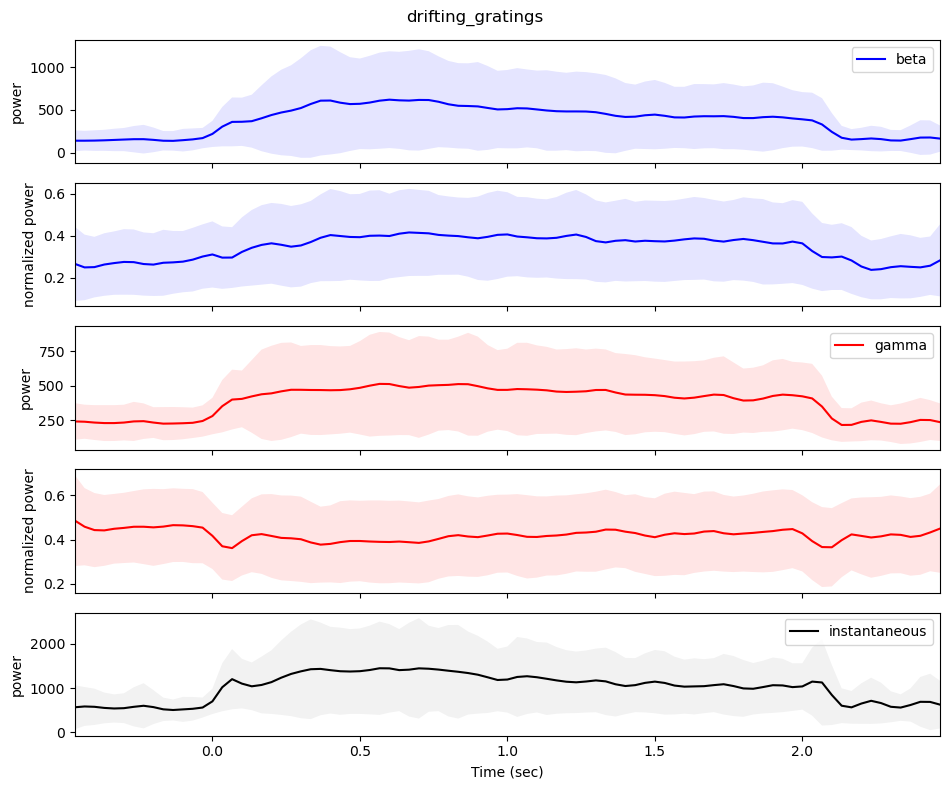

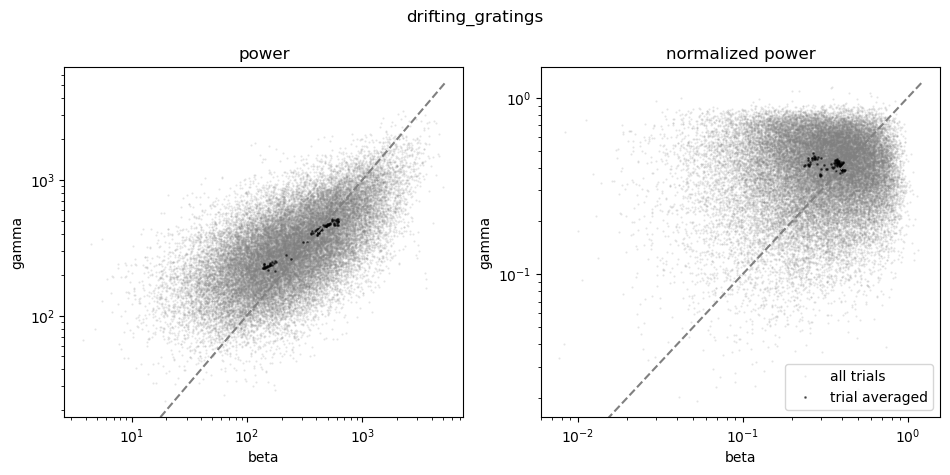

natural_movie_one


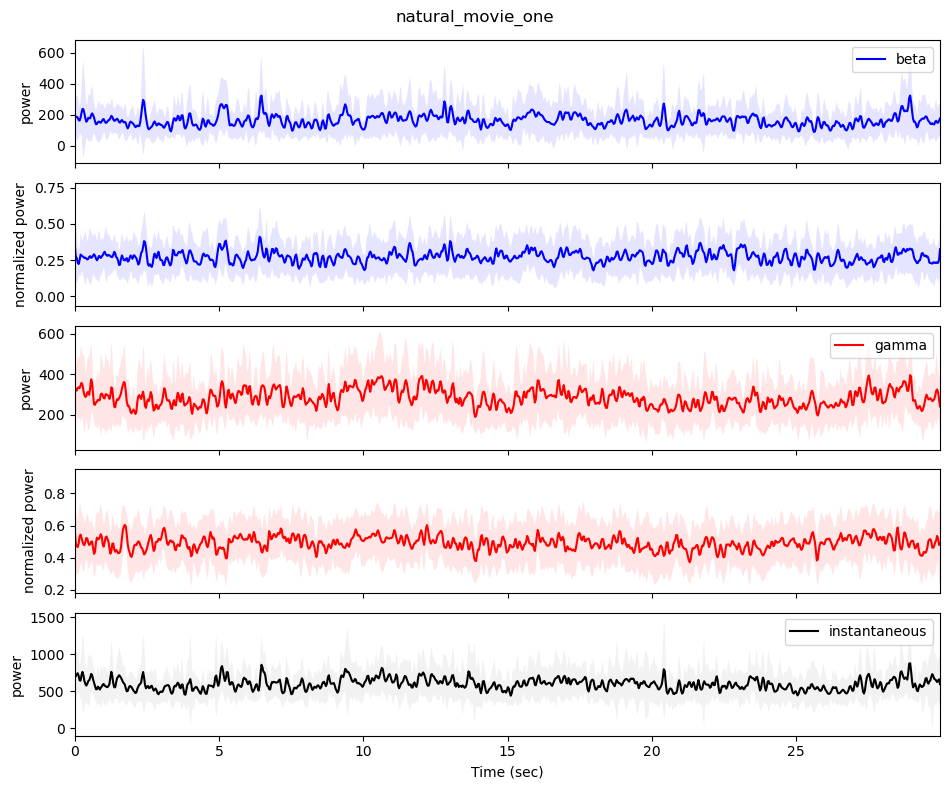

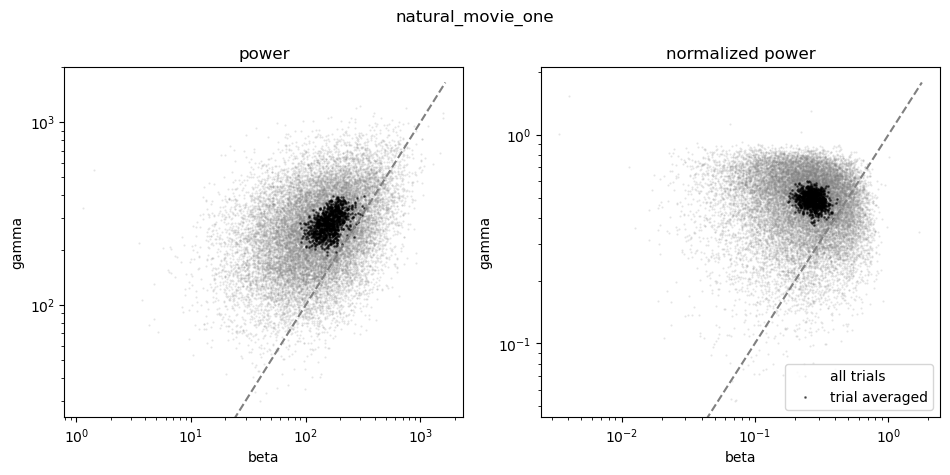

natural_movie_three


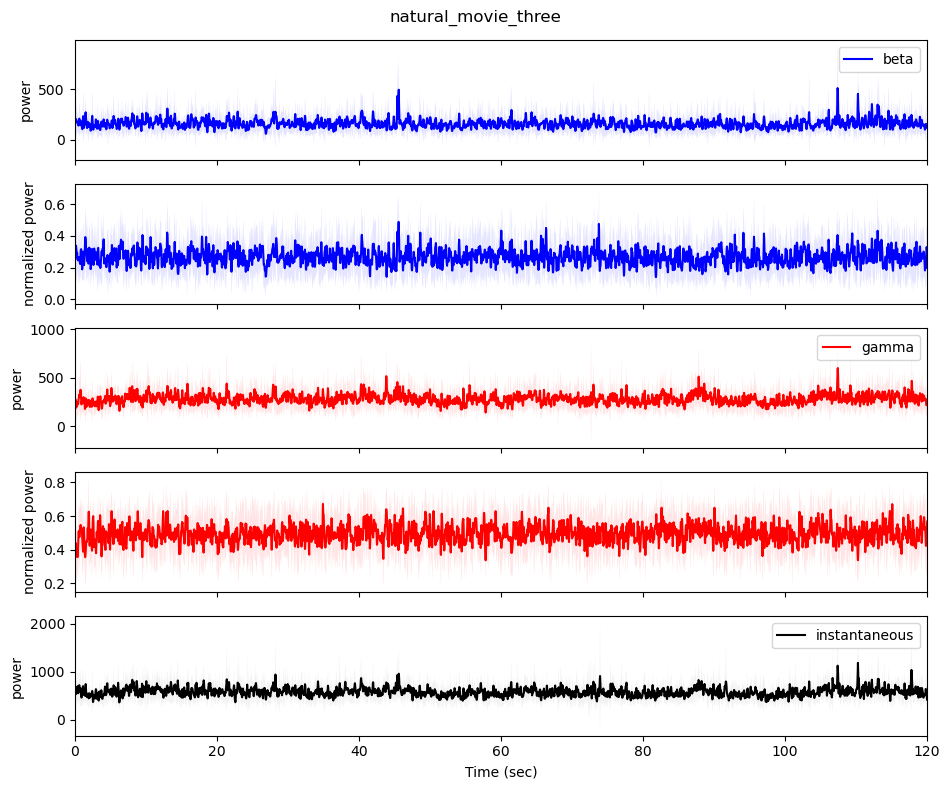

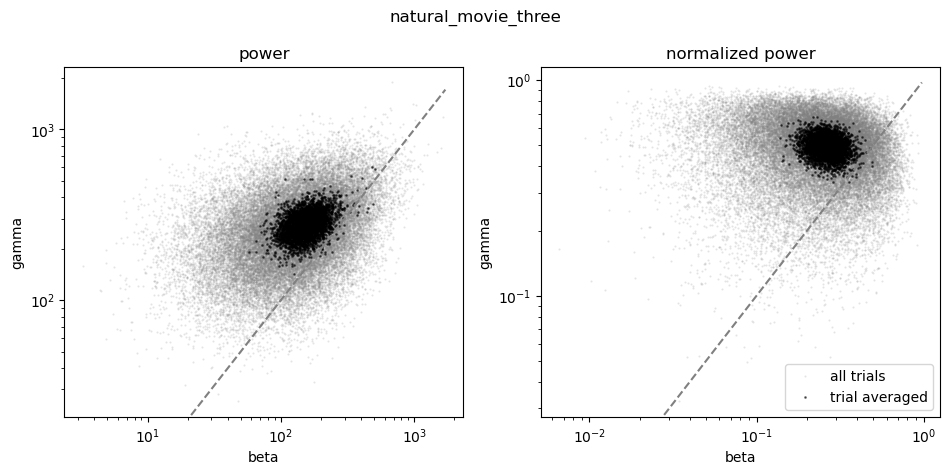

In [ ]:
if plot_example_traces:
    from toolkit.plots.colors import BAND_COLORS
    log_scale = True
    for stim in stimulus_names:
        print(stim)
        fig1, axs1 = plt.subplots(5, 1, figsize=(9.6, 8.0), sharex=True)
        fig2, axs2 = plt.subplots(1, 2, figsize=(9.6, 4.8))
        # instantaneous power
        ax = axs1[-1]
        da = instantaneous_power[stim]
        t = da.coords[time_dim].values
        x_mean = da.mean(dim=presentation_dim)
        x_std = da.std(dim=presentation_dim)
        ax.plot(t, x_mean, color='k', label='instantaneous')
        ax.fill_between(t, x_mean - x_std, x_mean + x_std, facecolor='gray', edgecolor='none', alpha=0.1)
        ax.set_xlim(t[0], t[-1])
        ax.set_ylabel('power')
        ax.legend(loc='upper right')
        # band power
        for i, da in enumerate([smoothed_band_power[stim], normalized_band_power[stim]]):
            var = 'normalized power' if i == 1 else 'power'
            pow_mean = []
            for ax, w in zip(axs1[i::2], wave_bands):
                x = da.sel(wave_band=w)
                x_mean = x.mean(dim=presentation_dim)
                pow_mean.append(x_mean.values.ravel())
                x_std = x.std(dim=presentation_dim)
                ax.plot(t, x_mean, color=BAND_COLORS[w], label=w)
                ax.fill_between(t, x_mean - x_std, x_mean + x_std, facecolor=BAND_COLORS[w], edgecolor='none', alpha=0.1)
                ax.set_xlim(t[0], t[-1])
                ax.set_ylabel(var)
                if i == 0:
                    ax.legend(loc='upper right')

            pow = [da.sel(wave_band=w).values.ravel() for w in wave_bands]
            ax = axs2[i]
            ax.plot(*pow, '.', color='gray', markersize=1, alpha=0.2, label='all trials')
            ax.plot(*pow_mean, '.', color='k', markersize=2, alpha=0.5, label='trial averaged')
            xl = ax.get_xlim()
            ax.plot(xl, xl, color='gray', linestyle='--')
            if log_scale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel(wave_bands[0])
            ax.set_ylabel(wave_bands[1])
            ax.set_title(var)
        ax.legend(loc='lower right')
        axs1[-1].set_xlabel('Time (sec)')
        fig1.suptitle(stim)
        fig2.suptitle(stim)
        fig1.tight_layout()
        fig2.tight_layout()
        plt.show()

### Get firing rate statistics

In [18]:
units_fr = concat_stack_xarray_dims(units_frs.values(), exclude_dims=['unit_id'], reindex=True)

units_fr = units_fr.to_dataset(name='firing_rate').assign(
    units_fr_mean = units_fr.mean(dim='sample'),
    units_fr_std = units_fr.std(dim='sample'),
    units_fr_min = units_fr.min(dim='sample'),
    units_fr_max = units_fr.max(dim='sample'),
)

In [19]:
# Get Soft-normalization parameters (Churchland et al. 2012)
normalization_scale = 'std' # 'max', 'std', 'mean'
quantile = 0.2

norm_scale = units_fr['units_fr_' + normalization_scale]
soft_normalize_cut = np.quantile(norm_scale, quantile)

soft_normalization = dict(
    normalization_scale=normalization_scale,
    quantile=quantile,
    cut=soft_normalize_cut
)
session_dir.save_soft_normalization(soft_normalization)

#### Plot units firing statistics

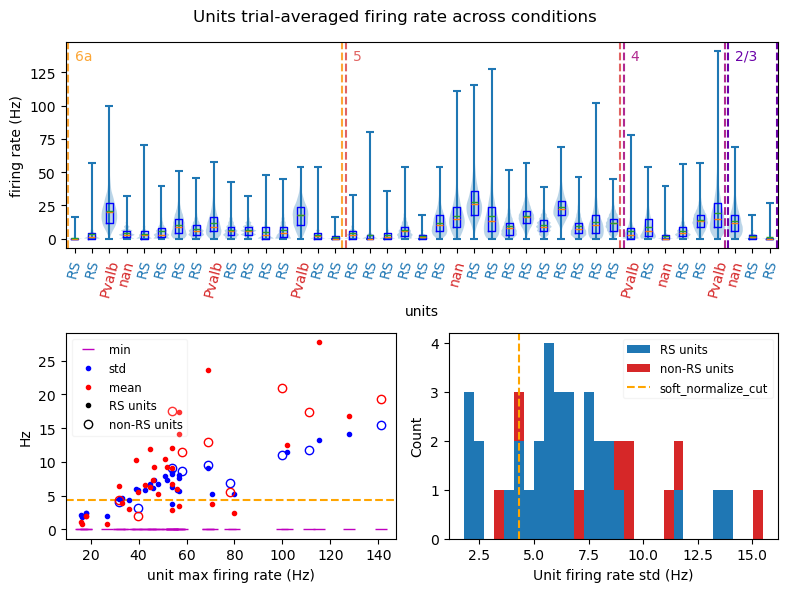

In [20]:
from toolkit.plots.colors import VISP_LAYER_COLORS_DICT

n_all_units = len(units_info)
unit_layer = units_info['layer_acronym'].values
layer_boundary_idx = np.nonzero(unit_layer[:-1] != unit_layer[1:])[0]
layer_boundary_idx = np.hstack([-1, layer_boundary_idx, unit_layer.size - 1])
is_RS = units_info['unit_type'].values == 'RS'
positions = np.arange(n_all_units)
boundary_gap = 0.1
firing_rate = units_fr.firing_rate.values.T  # (samples, units)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1)
ax.violinplot(firing_rate, positions=positions, widths=.9)
ax.boxplot(firing_rate, positions=positions, widths=0.4, whis=(0, 100),
    showmeans=True, meanline=True, showfliers=False, showcaps=False,
    meanprops={'linestyle': '-'}, whiskerprops={'color':'none'}, boxprops={'color': 'blue'})
for i in layer_boundary_idx[:-1]:
    clr = VISP_LAYER_COLORS_DICT[unit_layer[i + 1]]
    ax.axvline(i + 0.5 + boundary_gap, linestyle='--', color=clr)
    ax.annotate(unit_layer[i + 1], xy=(i + 0.5 + boundary_gap, ax.get_ylim()[1]),
        xytext=(5, -5), textcoords='offset points', ha='left', va='top', color=clr)
for i in layer_boundary_idx[1:]:
    ax.axvline(i + 0.5 - boundary_gap, linestyle='--', color=VISP_LAYER_COLORS_DICT[unit_layer[i]])
ax.set_xticks(positions, labels=units_info['unit_type'], rotation=75)
for lb in ax.get_xticklabels():
    lb.set_color('tab:blue' if lb.get_text() == 'RS' else 'tab:red')
# ax.set_xticklabels()
ax.set_xlabel('units')
ax.set_ylabel('firing rate (Hz)')

ax = fig.add_subplot(2, 2, 3)
ax.axhline(soft_normalize_cut, linestyle='--', color='orange')
ax.plot(units_fr.units_fr_max, units_fr.units_fr_min, 'm.', marker='_', markersize=8, label='min')
ax.plot(units_fr.units_fr_max[is_RS], units_fr.units_fr_std[is_RS], 'b.', label='std')
ax.plot(units_fr.units_fr_max[~is_RS], units_fr.units_fr_std[~is_RS], 'bo', markerfacecolor='none')
ax.plot(units_fr.units_fr_max[is_RS], units_fr.units_fr_mean[is_RS], 'r.', label='mean')
ax.plot(units_fr.units_fr_max[~is_RS], units_fr.units_fr_mean[~is_RS], 'ro', markerfacecolor='none')
ax.plot([], [], 'k.', label='RS units')
ax.plot([], [], 'ko', markerfacecolor='none', label='non-RS units')
ax.set_xlabel('unit max firing rate (Hz)')
ax.set_ylabel('Hz')
ax.legend(loc='upper left', framealpha=0.2, fontsize='small')

ax = fig.add_subplot(2, 2, 4)
ax.hist([norm_scale[is_RS], norm_scale[~is_RS]], bins=30, stacked=True,
    color=['tab:blue', 'tab:red'], label=['RS units', 'non-RS units'])
ax.axvline(soft_normalize_cut, linestyle='--', color='orange', label='soft_normalize_cut')
ax.set_xlabel(f'Unit firing rate {normalization_scale:s} (Hz)')
ax.set_ylabel('Count')
ax.legend(loc='upper right', framealpha=0.2, fontsize='small')

fig.suptitle('Units trial-averaged firing rate across conditions')
fig.tight_layout()
plt.show()

### Compute smoothed spike rate of selected units

In [21]:
select_RS = True
select_layer = False

# Select only Regular Spiking (RS) units
unit_idx = np.ones(all_units_id.size, dtype=bool)
if select_RS:
    unit_idx = units_info['unit_type'] == 'RS'
if select_layer:
    if select_layer is True:
        select_layer = [layer_of_interest]
    unit_idx = units_info['layer_acronym'].isin(select_layer)

units_id = all_units_id[unit_idx]
print(f"Number of RS units: {units_id.size}/{all_units_id.size}")

Number of RS units: 32/41


In [22]:
units_smoothed_rate = {}
units_averaged_rate = {}
for stim in stimulus_names:
    units_smoothed_rate[stim] = smooth_spike_rate(
        units_spk_rate[stim].sel(unit_id=units_id), sigma,
        normalization_scale=norm_scale.sel(unit_id=units_id) if normalize_unit_fr else None,
        soft_normalize_cut=soft_normalize_cut if soft_normalize else 0,
        time_dim='time_relative_to_stimulus_onset'
    )
    units_averaged_rate[stim] = units_frs[stim].sel(unit_id=units_id)

#### Plot example units firing traces in drifting gratings

In [23]:
if plot_example_traces:
    show_n_units = 3
    rng = np.random.default_rng(seed=42)
    show_units = np.sort(rng.choice(units_id, show_n_units, replace=False))

    figsize = (4, 1.6)
    v_offset = 0.3
    if 'drifting_gratings' in stimulus_names:
        print("Stimulus 'drifting_gratings': Unit firing rate across trials")
        n_row = conditions.orientation.size
        n_col = conditions.temporal_frequency.size
        frs = units_smoothed_rate['drifting_gratings']
        t = frs.time_relative_to_stimulus_onset.values
        for unit_id in show_units:
            fr = frs.sel(unit_id=unit_id)
            fig, axs = plt.subplots(n_row, n_col, figsize=(figsize[0] * n_col, figsize[1] * n_row), squeeze=False)
            for i, orient in enumerate(conditions.orientation.values):
                for j, temp_freq in enumerate(conditions.temporal_frequency.values):
                    ax = axs[i, j]
                    cond_id = conditions.sel(orientation=orient, temporal_frequency=temp_freq).item()
                    stimulus_presentation_id = cond_presentation_id[cond_id]
                    n_sid = stimulus_presentation_id.size - 1
                    for k, sid in enumerate(stimulus_presentation_id):
                        ax.plot(t, (n_sid - k) * v_offset + fr.sel(stimulus_presentation_id=sid).values)
                        ax.set_xlim(t[0], t[-1])
                    if i == 0:
                        ax.set_title(f"{temp_freq:.0f} Hz")
                    if i == n_row - 1:
                        ax.set_xlabel('Time (sec)')
                    else:
                        ax.set_xticks([])
                axs[i, 0].set_ylabel(f"{orient:.0f} deg")
            unit_str = f"Unit {unit_id:d}: layer {units_info.loc[unit_id, 'layer_acronym']}, " \
                f"type {units_info.loc[unit_id, 'unit_type']}"
            fig.suptitle(unit_str, fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.95)
        plt.show()

## PCA analysis

In [24]:
n_pc_range = (3, 6)  # range of principal components to choose

In [25]:
n_units = units_id.size
n_samples_stim = {}  # total number of time samples per stimulus
n_trials_stim = {}  # average number of trials per stimulus condition
for stim in stimulus_names:
    n_samples_stim[stim] = units_smoothed_rate[stim].size // n_units
    n_trials_stim[stim] = units_smoothed_rate[stim].size / units_averaged_rate[stim].size

# Calculate mean firing rate across all stimuli
units_fr_mean = concat_stack_xarray_dims(
    units_smoothed_rate.values(), exclude_dims=['unit_id']).mean(dim='sample')
# Concatenate trial-averaged firing rate samples weighted by the number of trials
units_vec = concat_stack_xarray_dims(
    [n_trials_stim[stim] * (da - units_fr_mean) for stim, da in units_averaged_rate.items()],
    exclude_dims=['unit_id']).transpose('sample', 'unit_id')

Explained variance % of top 7 components: 
20.48, 18.98, 7.45, 6.55, 6.24, 4.00, 3.41
Explained variance % drop of top 7 components: 
7.3, 60.7, 12.1, 4.6, 36.0, 14.7


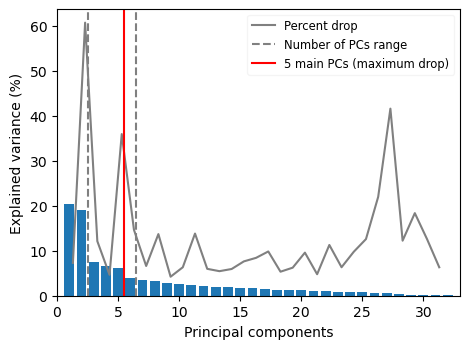

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_units)
pca.fit(units_vec)

# Determine number of main principal components as maximum explained variance drop
ev = pca.explained_variance_ratio_
ev_drop = ev[1:] / ev[:-1]
n_main_pc = np.argmin(ev_drop[n_pc_range[0] - 1:n_pc_range[1]]) + n_pc_range[0]

print(f"Explained variance % of top {n_pc_range[1] + 1} components: \n" + 
      ', '.join('%.2f' % (100 * x) for x in ev[:n_pc_range[1] + 1]))
print(f"Explained variance % drop of top {n_pc_range[1] + 1} components: \n" + 
      ', '.join('%.1f' % (100 * (1 - x)) for x in ev_drop[:n_pc_range[1]]))

fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.6))
ax.bar(np.arange(n_units) + 1, 100 * ev)
yl = ax.get_ylim()[1]
ax.plot(np.arange(n_units - 1) + 1.3, 100 * (1 - ev_drop), 'gray', label='Percent drop')
ax.axvline(n_pc_range[0] - 0.5, linestyle='--', color='gray', label='Number of PCs range')
ax.axvline(n_pc_range[1] + 0.5, linestyle='--', color='gray')
ax.axvline(n_main_pc + 0.5, color='r', label=f'{n_main_pc} main PCs (maximum drop)')
ax.set_xlim(0, min(n_units, 50) + 1)
# ax.set_ylim(0, yl)
ax.set_xlabel('Principal components')
ax.set_ylabel('Explained variance (%)')
ax.legend(loc='upper right', framealpha=0.2, fontsize='small')
fig.tight_layout()
plt.show()

In [35]:
pca_parameters = dict(
    n_samples_stim=n_samples_stim,
    n_trials_stim=n_trials_stim,
    n_main_pc=n_main_pc,
)
session_dir.save_pca_parameters(pca_parameters)

In [58]:
pop_vecs = {}
for stim, da in units_smoothed_rate.items():
    pop_vec = stack_xarray_dims(da, exclude_dims=['unit_id'], create_index=True).transpose('sample', 'unit_id')
    pop_vec = pop_vec.copy(data=pca.transform(pop_vec)).rename(unit_id='PC').unstack('sample')
    pop_vecs[stim] = pop_vec.assign_coords(PC=range(n_units))

### Population trajectories and relation with wave power

In [60]:
absolute_origin = True

pc_dims = ('PC', 'sample')

cmap = 'jet'

#### Calculate averaged firing rate across units

In [55]:
mean_tot_frs = {}  # mean total (normalized) firing rate of all units
rms_frs = {}  # root mean square firing rate of all units
for stim, da in units_smoothed_rate.items():
    frs = da.isel({time_dim: slice(1, None)})
    mean_tot_frs[stim] = frs.mean(dim='unit_id')
    rms_frs[stim] = np.sqrt((frs ** 2).mean(dim='unit_id'))

In [61]:
if absolute_origin:
    pop_vec_org = pca.transform(np.zeros([1, n_units]))[0]
else:
    pop_vec_org = np.zeros(n_units)
pop_vec_org = xr.DataArray(pop_vec_org, coords=dict(PC=range(n_units)))

pop_vels = {}  # velocity
pop_speeds = {}  # speed along main PCs
pop_angs = {}  # angle changed along main PCs
pop_lengths = {}  # length of population vector along main PCs
pop_radials = {}  # radial speed
pop_tangents = {}  # tangent speed
for stim, pop_vec in pop_vecs.items():
    pop_vec = (pop_vec - pop_vec_org).sel(PC=range(n_main_pc))  # consider only main PCs
    pop_vec_len = (pop_vec ** 2).sum(dim='PC') ** 0.5
    pop_vec0 = pop_vec.isel(time_relative_to_stimulus_onset=slice(1, None))
    pop_vec1 = pop_vec.isel(time_relative_to_stimulus_onset=slice(None, -1))
    pop_vec0_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(1, None))
    pop_vec1_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(None, -1))
    # velocity
    pop_vel = pop_vec0.copy(data=pop_vec0.values - pop_vec1.values)
    pop_vels[stim] = pop_vel
    # speed
    pop_speeds[stim] = speed = (pop_vel ** 2).sum(dim='PC') ** 0.5
    # angle
    pc_axis = pop_vec.dims.index('PC')
    dot = np.sum(pop_vec0.values * pop_vec1.values, axis=pc_axis)
    pop_angs[stim] = speed.copy(data=np.degrees(np.arccos(dot / (pop_vec0_len.values * pop_vec1_len.values))))
    # radial/tangent speed
    pop_lengths[stim] = pop_vec0_len
    unit_vec0 = pop_vec0 / pop_vec0_len
    radial_vel = np.sum(unit_vec0.values * pop_vel.values, axis=pc_axis)
    pop_radials[stim] = radial_vel = pop_vec0_len.copy(data=radial_vel)
    tangent_vel = pop_vel - radial_vel * unit_vec0
    pop_tangents[stim] = (tangent_vel ** 2).sum(dim='PC') ** 0.5

In [ ]:
# from toolkit.utils.module import reload_module

# # st = reload_module(st)
# stack_xarray_dims = reload_module('toolkit.analysis.utils', 'stack_xarray_dims')
# concat_stack_xarray_dims = reload_module('toolkit.analysis.utils', 'concat_stack_xarray_dims')